# KimiaNet on Kather et al. (2016) CRC Textures


This notebook fine-tunes **KimiaNet** (DenseNet‑121 backbone) to classify the 8 colorectal histology texture classes from **Kather et al., Scientific Reports (2016)**.

**Dataset:** *Collection of textures in colorectal cancer histology* (DOI: 10.5281/zenodo.53169).  
**Classes (8):** tumor epithelium, simple stroma, complex stroma, immune cells, debris, normal mucosal glands, adipose, background.



## 0. Configuration & Imports

In [2]:

import os, sys, glob, zipfile, shutil, random, math, itertools, pathlib, time
from dataclasses import dataclass
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt


# Paths
BASE_DIR = os.path.abspath("./kather_kimianet_workspace")
DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DIR  = os.path.join(DATA_DIR, "raw")
IMG_DIR  = os.path.join(DATA_DIR, "Kather_texture_2016_image_tiles_5000")
LARGE_DIR= os.path.join(DATA_DIR, "Kather_texture_2016_larger_images_10")
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")    
KIMIANET_WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, "KimiaNetKerasWeights.h5")  


# Training config
IMG_SIZE = 224  # DenseNet-121 default; original tiles are 150x150 and need to be resized
NUM_CLASSES = 8
SEED = 42
BATCH_SIZE = 64
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = 15
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15


tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


## 1. Download dataset

In [3]:

import urllib.request
import os
import zipfile

ZENODO_BASE = "https://zenodo.org/records/53169/files"
TILES_ZIP = "Kather_texture_2016_image_tiles_5000.zip"
LARGE_ZIP = "Kather_texture_2016_larger_images_10.zip"

# Only download if not in folder
def maybe_download(url, dst):
    if os.path.exists(dst):
        print("Exists:", dst)
        return
    print("Downloading:", url)
    urllib.request.urlretrieve(url, dst)
    print("Saved to:", dst)


def maybe_unzip(zip_path, dst_dir):
    if not os.path.exists(zip_path):
        print("Zip not found:", zip_path)
        return

    # Create destination directory if it doesn't exist
    os.makedirs(dst_dir, exist_ok=True)

    # Extract all files from the zip archive
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(dst_dir)

    print("Extracted to:", dst_dir)

tiles_zip_path = os.path.join(RAW_DIR, TILES_ZIP)
large_zip_path = os.path.join(RAW_DIR, LARGE_ZIP)

try:
    maybe_download(f"{ZENODO_BASE}/{TILES_ZIP}", tiles_zip_path)
    maybe_download(f"{ZENODO_BASE}/{LARGE_ZIP}", large_zip_path)
    maybe_unzip(tiles_zip_path, DATA_DIR)
    maybe_unzip(large_zip_path, DATA_DIR)
except Exception as e:
    print("Download skipped or failed:", e)


Exists: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data\raw\Kather_texture_2016_image_tiles_5000.zip
Exists: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data\raw\Kather_texture_2016_larger_images_10.zip
Extracted to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data
Extracted to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data


## 2. Verify dataset layout & class names

In [4]:

# The IMG_DIR should have folders for each tissue type
expected_classes = [
    '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'
]

if not os.path.isdir(IMG_DIR):
    raise FileNotFoundError(f"Couldn't find the tiles folder: {IMG_DIR}")

classes = sorted([d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR,d))])
print("Found classes:", classes)

# Check if we have all the classes we expect
missing = [c for c in expected_classes if c not in classes]
if missing:
    print("Some expected classes not found:", missing)
    
# Count images per class
for c in classes:
    cnt = len(glob.glob(os.path.join(IMG_DIR, c, "*.png"))) + len(glob.glob(os.path.join(IMG_DIR, c, "*.tif"))) + len(glob.glob(os.path.join(IMG_DIR, c, "*.jpg")))
    print(f"{c:20s}: {cnt}")


Found classes: ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
01_TUMOR            : 625
02_STROMA           : 625
03_COMPLEX          : 625
04_LYMPHO           : 625
05_DEBRIS           : 625
06_MUCOSA           : 625
07_ADIPOSE          : 625
08_EMPTY            : 625


## 3. Train/Val/Test split (stratified by class)

In [5]:

from collections import defaultdict

def stratified_split(image_root, val_split=0.15, test_split=0.15, seed=SEED):
    rng = random.Random(seed)
    class_to_paths = defaultdict(list)
    for c in sorted(os.listdir(image_root)):
        cdir = os.path.join(image_root, c)
        if not os.path.isdir(cdir): 
            continue
        files = []
        for ext in ("*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"):
            files.extend(glob.glob(os.path.join(cdir, ext)))
        files = sorted(files)
        rng.shuffle(files)
        class_to_paths[c] = files
    
    train, val, test = [], [], []
    for c, paths in class_to_paths.items():
        n = len(paths)
        n_test = int(round(n * test_split))
        n_val  = int(round(n * val_split))
        test.extend([(p, c) for p in paths[:n_test]])
        val.extend([(p, c) for p in paths[n_test:n_test+n_val]])
        train.extend([(p, c) for p in paths[n_test+n_val:]])
    return train, val, test

train_samples, val_samples, test_samples = stratified_split(IMG_DIR, VAL_SPLIT, TEST_SPLIT, SEED)
print(len(train_samples), len(val_samples), len(test_samples))



3496 752 752


## 4. tf.data pipelines (+ augmentations)

In [6]:

AUTOTUNE = tf.data.AUTOTUNE
class_names = sorted(list({c for _, c in train_samples}))
class_to_idx = {c:i for i,c in enumerate(class_names)}
print("Class mapping:", class_to_idx)

from PIL import Image
import numpy as np
import tensorflow as tf

def _pil_read(path):
    # Convert tensor to string and decode bytes to string
    path_str = path.numpy().decode('utf-8')
    with Image.open(path_str) as im:
        arr = np.array(im, dtype=np.uint8)
    return arr

def decode_img(path):
    img = tf.py_function(func=_pil_read, inp=[path], Tout=tf.uint8)
    img.set_shape([None, None, 3])
    return img

def preprocess(path, label):
    img = decode_img(path)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.int32)



def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    # 90-degree rotations (k in {0,1,2,3})
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    # light color jitter
    img = tf.image.random_brightness(img, max_delta=0.02)
    img = tf.image.random_contrast(img, lower=0.95, upper=1.05)
    return img, label

def make_ds(samples, training=False, batch_size=BATCH_SIZE):
    paths = [p for p,_ in samples]
    labels = [class_to_idx[c] for _,c in samples]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_samples, training=True)
val_ds   = make_ds(val_samples, training=False)
test_ds  = make_ds(test_samples, training=False)

for imgs, labs in train_ds.take(1):
    print("Batch:", imgs.shape, labs.shape)


Class mapping: {'01_TUMOR': 0, '02_STROMA': 1, '03_COMPLEX': 2, '04_LYMPHO': 3, '05_DEBRIS': 4, '06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7}
Batch: (64, 224, 224, 3) (64,)


## 5. Build model (KimiaNet → 8‑class head)

In [7]:

# DenseNet-121 backbone

backbone = keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Try to load KimiaNet weights
if os.path.isfile(KIMIANET_WEIGHTS_PATH):
    try:
        print("Loading KimiaNet weights from:", KIMIANET_WEIGHTS_PATH)
        backbone.load_weights(KIMIANET_WEIGHTS_PATH, by_name=True, skip_mismatch=True)
        print("KimiaNet weights loaded (by_name, skip_mismatch)." )
    except Exception as e:
        print("Failed to load KimiaNet weights:", e)

x = layers.GlobalAveragePooling2D()(backbone.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs=backbone.input, outputs=out)

# Phase A: warm-up — freeze backbone
for l in backbone.layers:
    l.trainable = False

model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Loading KimiaNet weights from: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\weights\KimiaNetKerasWeights.h5
KimiaNet weights loaded (by_name, skip_mismatch).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,049,800 (26.89 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

## 6. Train — Phase A (head only)

In [8]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
hist_a = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_WARMUP, callbacks=callbacks)


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6101 - loss: 0.9845 - val_accuracy: 0.4747 - val_loss: 1.3498
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 975ms/step - accuracy: 0.7245 - loss: 0.7109 - val_accuracy: 0.6689 - val_loss: 0.8559
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 996ms/step - accuracy: 0.7446 - loss: 0.6416 - val_accuracy: 0.7274 - val_loss: 0.7412
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 994ms/step - accuracy: 0.7717 - loss: 0.6104 - val_accuracy: 0.7739 - val_loss: 0.6552
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 981ms/step - accuracy: 0.7786 - loss: 0.5829 - val_accuracy: 0.7726 - val_loss: 0.6379


## 7. Train — Phase B (gradual unfreeze last dense block)

In [9]:

# Unfreeze specific layers in the backbone for fine-tuning
# We want to train only the deeper layers that contain more specialized features
unfreeze = False
for l in backbone.layers:
    name = l.name.lower()
    # Look for the last dense block (block 4) or conv5 layers in DenseNet-121
    # These are the deeper layers that capture more complex, domain-specific features
    if ('conv5' in name) or ('dense_block4' in name) or ('bn' in name and 'conv5' in name):
        unfreeze = True
    if unfreeze:
        l.trainable = True  # Make these layers trainable

# Re-compile the model with a smaller learning rate for fine-tuning
# Lower learning rate helps make subtle adjustments without destroying pre-trained weights
model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
hist_b = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINETUNE, callbacks=callbacks)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7483 - loss: 0.6850 - val_accuracy: 0.6356 - val_loss: 0.9600
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8275 - loss: 0.4826 - val_accuracy: 0.6662 - val_loss: 0.8540
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8355 - loss: 0.4583 - val_accuracy: 0.7207 - val_loss: 0.6752
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8447 - loss: 0.4150 - val_accuracy: 0.8511 - val_loss: 0.4760
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8513 - loss: 0.3979 - val_accuracy: 0.8564 - val_loss: 0.4102
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8604 - loss: 0.3706 - val_accuracy: 0.8670 - val_loss: 0.3727
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8678 - loss: 0.3584 - val_accuracy: 0.8777 - val_loss: 0.3551
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8784 - loss: 0.3404 - val_accuracy: 0.8803 - val_loss:

## 8. Evaluation — metrics & confusion matrix

              precision    recall  f1-score   support

    01_TUMOR     0.9670    0.9362    0.9514        94
   02_STROMA     0.9176    0.8298    0.8715        94
  03_COMPLEX     0.8037    0.9149    0.8557        94
   04_LYMPHO     0.9762    0.8723    0.9213        94
   05_DEBRIS     0.8878    0.9255    0.9062        94
   06_MUCOSA     0.9149    0.9149    0.9149        94
  07_ADIPOSE     0.9368    0.9468    0.9418        94
    08_EMPTY     0.9490    0.9894    0.9688        94

    accuracy                         0.9162       752
   macro avg     0.9191    0.9162    0.9165       752
weighted avg     0.9191    0.9162    0.9165       752



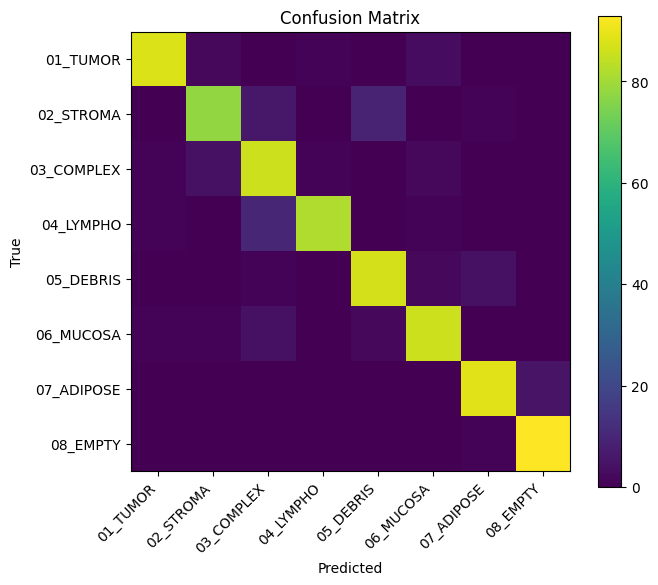

In [10]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect predictions
y_true = []
y_pred = []
for imgs, labs in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labs.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


## 10. Save model & class mapping

In [11]:
import json
SAVE_DIR = os.path.join(BASE_DIR, 'artifacts')
os.makedirs(SAVE_DIR, exist_ok=True)

# Save Keras model
model_path = os.path.join(SAVE_DIR, 'kimianet_kather_classifier.keras')
model.save(model_path)
print('Saved model to:', model_path)

# Save class mapping
with open(os.path.join(SAVE_DIR, 'class_to_idx.json'), 'w') as f:
    json.dump(class_to_idx, f, indent=2)
print('Saved class mapping.')


Saved model to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\artifacts\kimianet_kather_classifier.keras
Saved class mapping.
